In [5]:
# =========================================
# Step 0: Install dependencies (if needed)
# =========================================
# pip install pm4py rapidfuzz pandas

import pm4py
import pandas as pd
from rapidfuzz import fuzz, process
from datetime import timedelta

In [2]:
# =========================================
# Step 1: Load BPI P2P Event Log
# =========================================
# Make sure you download a BPI Challenge log, e.g., "BPI_Challenge_2019.xes" from 4TU Data Centre
xes_file = "data/BPI_Challenge_2012.xes"  

log = pm4py.read_xes(xes_file)
df = pm4py.convert_to_dataframe(log)

print("Event log structure:")
print(df.head())

# =========================================

/Users/u.srinivasan/Documents/Projects_Garage/Duplicate-Invoice-Solution/dcenv/lib/python3.11/site-packages/pm4py/utils.py:800: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

Event log structure:
  org:resource lifecycle:transition            concept:name  \
0          112             COMPLETE             A_SUBMITTED   
1          112             COMPLETE       A_PARTLYSUBMITTED   
2          112             COMPLETE           A_PREACCEPTED   
3          112             SCHEDULE  W_Completeren aanvraag   
4          NaN                START  W_Completeren aanvraag   

                    time:timestamp                    case:REG_DATE  \
0 2011-10-01 00:38:44.546000+00:00 2011-10-01 00:38:44.546000+00:00   
1 2011-10-01 00:38:44.880000+00:00 2011-10-01 00:38:44.546000+00:00   
2 2011-10-01 00:39:37.906000+00:00 2011-10-01 00:38:44.546000+00:00   
3 2011-10-01 00:39:38.875000+00:00 2011-10-01 00:38:44.546000+00:00   
4 2011-10-01 11:36:46.437000+00:00 2011-10-01 00:38:44.546000+00:00   

  case:concept:name case:AMOUNT_REQ  
0            173688           20000  
1            173688           20000  
2            173688           20000  
3            173688  

In [4]:
# =========================================
# Step 2: Extract Application-Related Events
# =========================================
# Keep only activities related to the loan application (those starting with "A_")
application_df = df[df['concept:name'].str.startswith("A_", na=False)].copy()

# Keep only relevant fields
application_df = application_df[['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp']]
application_df = application_df.rename(columns={
    'case:concept:name': 'application_id',
    'concept:name': 'activity',
    'org:resource': 'user',
    'time:timestamp': 'timestamp'
})

print("Application-related events:")
print(application_df.head())


Application-related events:
  application_id           activity   user                        timestamp
0         173688        A_SUBMITTED    112 2011-10-01 00:38:44.546000+00:00
1         173688  A_PARTLYSUBMITTED    112 2011-10-01 00:38:44.880000+00:00
2         173688      A_PREACCEPTED    112 2011-10-01 00:39:37.906000+00:00
5         173688         A_ACCEPTED  10862 2011-10-01 11:42:43.308000+00:00
7         173688        A_FINALIZED  10862 2011-10-01 11:45:09.243000+00:00


In [ ]:
# =========================================
# Step 3: Create Realistic Duplicate Applications
# =========================================
import random
from datetime import timedelta

def create_realistic_duplicates(df, num_duplicates=10):
    """
    Create realistic duplicates that simulate common duplicate scenarios:
    1. Manual re-entry by same user (typos, slight variations)
    2. Multiple users entering same application
    3. System retry/retransmission
    """
    duplicates = []
    
    # Get unique applications to duplicate
    unique_apps = df['application_id'].unique()
    apps_to_duplicate = random.sample(list(unique_apps), min(num_duplicates, len(unique_apps)))
    
    for app_id in apps_to_duplicate:
        original_app = df[df['application_id'] == app_id].copy()
        
        # Create 2-3 different types of duplicates for each application
        for dup_type in range(1, 4):  # Create 3 duplicates per app
            dup_app = original_app.copy()
            
            # Create slightly different application number (simulating manual entry errors)
            if dup_type == 1:
                # Type 1: Manual re-entry with slight variation (same user, within 1 hour)
                base_num = str(app_id)
                # Add small variation: swap digits, add/remove characters
                if len(base_num) > 3:
                    # Swap last two digits
                    new_num = base_num[:-2] + base_num[-1] + base_num[-2]
                else:
                    # Add a digit
                    new_num = base_num + str(random.randint(0, 9))
                
                dup_app['application_id'] = int(new_num)
                dup_app['application_number'] = new_num
                
                # Same user, but slightly later timestamp (within 1 hour)
                time_offset = timedelta(minutes=random.randint(5, 60))
                dup_app['timestamp'] = dup_app['timestamp'] + time_offset
                
            elif dup_type == 2:
                # Type 2: Different user, same time window (collaborative entry)
                base_num = str(app_id)
                # More significant variation
                new_num = base_num[:-1] + str((int(base_num[-1]) + 1) % 10)
                dup_app['application_id'] = int(new_num)
                dup_app['application_number'] = new_num
                
                # Different user (simulate different person entering)
                available_users = df['user'].dropna().unique()
                dup_app['user'] = random.choice([u for u in available_users if u != dup_app['user'].iloc[0]])
                
                # Within 2 hours of original
                time_offset = timedelta(minutes=random.randint(10, 120))
                dup_app['timestamp'] = dup_app['timestamp'] + time_offset
                
            else:
                # Type 3: System retry/retransmission (exact same data, different timestamp)
                base_num = str(app_id)
                # Very similar number (system might add prefix/suffix)
                new_num = "R" + base_num  # R for retry
                dup_app['application_id'] = new_num
                dup_app['application_number'] = new_num
                
                # Much later timestamp (system retry)
                time_offset = timedelta(hours=random.randint(2, 24))
                dup_app['timestamp'] = dup_app['timestamp'] + time_offset
            
            duplicates.append(dup_app)
    
    return pd.concat(duplicates, ignore_index=True)

# Create realistic duplicates
realistic_duplicates = create_realistic_duplicates(application_df, num_duplicates=5)

# Add application_number to original data
application_df['application_number'] = application_df['application_id'].astype(str)

# Combine original and duplicate data
combined_apps = pd.concat([application_df, realistic_duplicates], ignore_index=True)

print("Realistic duplicate creation completed:")
print(f"Original applications: {len(application_df)}")
print(f"Duplicate applications: {len(realistic_duplicates)}")
print(f"Total applications: {len(combined_apps)}")
print("\nSample of created duplicates:")
print(combined_apps[['application_id', 'application_number', 'user', 'timestamp']].tail(10))

Realistic duplicate creation completed:
Original applications: 60849
Duplicate applications: 54
Total applications: 60903

Sample of created duplicates:
      application_id application_number   user  \
60893         201212             201212  11000   
60894         201212             201212  11000   
60895         201212             201212  11000   
60896         201212             201212  11000   
60897        R201211            R201211    112   
60898        R201211            R201211    112   
60899        R201211            R201211    112   
60900        R201211            R201211  11121   
60901        R201211            R201211  11121   
60902        R201211            R201211  10629   

                             timestamp  
60893 2012-01-16 09:49:49.963000+00:00  
60894 2012-01-16 13:50:26.451000+00:00  
60895 2012-01-16 13:51:59.801000+00:00  
60896 2012-02-09 12:54:49.056000+00:00  
60897 2012-01-17 02:01:13.858000+00:00  
60898 2012-01-17 02:01:14.134000+00:00  
60899 201

In [14]:
# =========================================
# Step 4: Optimized Duplicate Detection using Fuzzy Matching
# =========================================
def detect_duplicates_optimized(df, threshold=80, max_comparisons=1000):
    """
    Optimized duplicate detection with multiple performance improvements:
    - Pre-filtering by length and prefix
    - Batch processing
    - Early termination
    - Caching
    """
    results = []
    
    # Get unique applications and pre-process
    apps = df[['application_number', 'user', 'activity', 'timestamp']].drop_duplicates()
    app_list = apps['application_number'].tolist()
    
    print(f"Processing {len(app_list)} unique applications...")
    
    # Pre-filter applications by length (similar lengths are more likely to be duplicates)
    app_lengths = {}
    for app in app_list:
        length = len(str(app))
        if length not in app_lengths:
            app_lengths[length] = []
        app_lengths[length].append(app)
    
    comparison_count = 0
    max_comparisons = min(max_comparisons, len(app_list) * 10)  # Limit comparisons
    
    # Only compare applications of similar lengths
    for length, apps_of_length in app_lengths.items():
        if len(apps_of_length) < 2:
            continue
            
        # Sort by prefix for better clustering
        apps_of_length.sort()
        
        for i in range(len(apps_of_length)):
            if comparison_count >= max_comparisons:
                print(f"Reached maximum comparisons limit ({max_comparisons})")
                break
                
            app_a = apps_of_length[i]
            
            # Only compare with nearby applications (reduces comparisons significantly)
            for j in range(i+1, min(i+50, len(apps_of_length))):  # Limit to 50 nearby apps
                app_b = apps_of_length[j]
                comparison_count += 1
                
                # Quick length check first
                if abs(len(str(app_a)) - len(str(app_b))) > 2:
                    continue
                
                # Fuzzy string similarity
                string_similarity = fuzz.ratio(str(app_a), str(app_b))
                
                if string_similarity >= threshold:
                    # Get traces efficiently
                    trace_a = df[df['application_number'] == app_a].sort_values('timestamp')
                    trace_b = df[df['application_number'] == app_b].sort_values('timestamp')
                    
                    if len(trace_a) > 0 and len(trace_b) > 0:
                        # Calculate metrics
                        time_diff = abs(trace_a['timestamp'].iloc[0] - trace_b['timestamp'].iloc[0])
                        user_similarity = 1.0 if trace_a['user'].iloc[0] == trace_b['user'].iloc[0] else 0.0
                        
                        # Quick activity similarity (only if traces are short)
                        if len(trace_a) <= 10 and len(trace_b) <= 10:
                            activities_a = trace_a['activity'].tolist()
                            activities_b = trace_b['activity'].tolist()
                            activity_similarity = fuzz.ratio(' '.join(activities_a), ' '.join(activities_b))
                        else:
                            activity_similarity = 0  # Skip expensive calculation for long traces
                        
                        results.append({
                            'Application_A': app_a,
                            'Application_B': app_b,
                            'String_Similarity': string_similarity,
                            'Time_Difference_Hours': time_diff.total_seconds() / 3600,
                            'Same_User': user_similarity,
                            'Activity_Similarity': activity_similarity,
                            'Trace_A': trace_a[['activity', 'user', 'timestamp']].to_dict('records'),
                            'Trace_B': trace_b[['activity', 'user', 'timestamp']].to_dict('records')
                        })
            
            if comparison_count >= max_comparisons:
                break
        
        if comparison_count >= max_comparisons:
            break
    
    print(f"Completed {comparison_count} comparisons in optimized mode")
    return pd.DataFrame(results)

# Detect duplicates with optimized analysis
duplicate_pairs = detect_duplicates_optimized(combined_apps, threshold=80, max_comparisons=5000)

print("Optimized duplicate detection results:")
print(f"Found {len(duplicate_pairs)} potential duplicate pairs")
if len(duplicate_pairs) > 0:
    print("\nSample results:")
    print(duplicate_pairs[['Application_A', 'Application_B', 'String_Similarity', 
                          'Time_Difference_Hours', 'Same_User', 'Activity_Similarity']].head())

Processing 60903 unique applications...
Completed 5047 comparisons in optimized mode
Optimized duplicate detection results:
Found 1383 potential duplicate pairs

Sample results:
  Application_A Application_B  String_Similarity  Time_Difference_Hours  \
0        173688        173688              100.0                    0.0   
1        173688        173688              100.0                    0.0   
2        173688        173688              100.0                    0.0   
3        173688        173688              100.0                    0.0   
4        173688        173688              100.0                    0.0   

   Same_User  Activity_Similarity  
0        1.0                100.0  
1        1.0                100.0  
2        1.0                100.0  
3        1.0                100.0  
4        1.0                100.0  


In [15]:
# =========================================
# Step 5: Advanced Root Cause Analysis
# =========================================
def advanced_root_cause_analysis(row):
    """
    Advanced root cause analysis based on multiple factors:
    - Temporal patterns
    - User behavior
    - Application number patterns
    - Activity sequences
    """
    app_a, app_b = row['Application_A'], row['Application_B']
    time_diff = row['Time_Difference_Hours']
    same_user = row['Same_User']
    string_sim = row['String_Similarity']
    activity_sim = row['Activity_Similarity']
    
    # Rule 1: Manual re-entry by same user (typos, corrections)
    if same_user and time_diff <= 1.0 and string_sim >= 85:
        return "Manual re-entry by same user (likely typo/correction)"
    
    # Rule 2: Collaborative entry by different users
    elif not same_user and time_diff <= 2.0 and string_sim >= 80:
        return "Collaborative entry by multiple users"
    
    # Rule 3: System retry/retransmission
    elif (app_a.startswith('R') or app_b.startswith('R')) and time_diff >= 2.0:
        return "System retry/retransmission"
    
    # Rule 4: Data migration/import issues
    elif time_diff >= 24 and activity_sim >= 90:
        return "Data migration/import duplicate"
    
    # Rule 5: Process workflow duplication
    elif time_diff <= 0.5 and activity_sim >= 95:
        return "Process workflow duplication"
    
    # Rule 6: User training/testing
    elif string_sim >= 90 and time_diff <= 0.1:
        return "User training/testing scenario"
    
    else:
        return "Complex duplicate scenario requiring manual review"

# Apply advanced root cause analysis
duplicate_pairs['Root_Cause'] = duplicate_pairs.apply(advanced_root_cause_analysis, axis=1)

print("Advanced root cause analysis completed:")
print("\nRoot cause distribution:")
print(duplicate_pairs['Root_Cause'].value_counts())

print("\nDetailed analysis results:")
for idx, row in duplicate_pairs.iterrows():
    print(f"\nPair {idx + 1}:")
    print(f"  Applications: {row['Application_A']} ↔ {row['Application_B']}")
    print(f"  String Similarity: {row['String_Similarity']:.1f}%")
    print(f"  Time Difference: {row['Time_Difference_Hours']:.2f} hours")
    print(f"  Same User: {row['Same_User']}")
    print(f"  Activity Similarity: {row['Activity_Similarity']:.1f}%")
    print(f"  Root Cause: {row['Root_Cause']}")

Advanced root cause analysis completed:

Root cause distribution:
Root_Cause
Complex duplicate scenario requiring manual review       1029
Manual re-entry by same user (likely typo/correction)     274
Process workflow duplication                               80
Name: count, dtype: int64

Detailed analysis results:

Pair 1:
  Applications: 173688 ↔ 173688
  String Similarity: 100.0%
  Time Difference: 0.00 hours
  Same User: 1.0
  Activity Similarity: 100.0%
  Root Cause: Manual re-entry by same user (likely typo/correction)

Pair 2:
  Applications: 173688 ↔ 173688
  String Similarity: 100.0%
  Time Difference: 0.00 hours
  Same User: 1.0
  Activity Similarity: 100.0%
  Root Cause: Manual re-entry by same user (likely typo/correction)

Pair 3:
  Applications: 173688 ↔ 173688
  String Similarity: 100.0%
  Time Difference: 0.00 hours
  Same User: 1.0
  Activity Similarity: 100.0%
  Root Cause: Manual re-entry by same user (likely typo/correction)

Pair 4:
  Applications: 173688 ↔ 173688


In [16]:
# =========================================
# Step 6: Duplicate Impact Analysis and Recommendations
# =========================================
def analyze_duplicate_impact(df, duplicate_pairs):
    """
    Analyze the business impact of duplicates and provide recommendations
    """
    impact_analysis = []
    
    for idx, row in duplicate_pairs.iterrows():
        app_a, app_b = row['Application_A'], row['Application_B']
        root_cause = row['Root_Cause']
        
        # Get application amounts (if available in original data)
        amount_a = df[df['application_number'] == app_a]['case:AMOUNT_REQ'].iloc[0] if 'case:AMOUNT_REQ' in df.columns else 0
        amount_b = df[df['application_number'] == app_b]['case:AMOUNT_REQ'].iloc[0] if 'case:AMOUNT_REQ' in df.columns else 0
        
        # Calculate risk level
        if root_cause in ["Manual re-entry by same user", "User training/testing scenario"]:
            risk_level = "Low"
            recommendation = "Implement input validation and auto-save features"
        elif root_cause in ["Collaborative entry by multiple users", "Process workflow duplication"]:
            risk_level = "Medium"
            recommendation = "Implement real-time duplicate checking and user coordination"
        elif root_cause in ["System retry/retransmission", "Data migration/import duplicate"]:
            risk_level = "High"
            recommendation = "Review system integration and data migration processes"
        else:
            risk_level = "Critical"
            recommendation = "Immediate manual review and process audit required"
        
        impact_analysis.append({
            'Application_A': app_a,
            'Application_B': app_b,
            'Root_Cause': root_cause,
            'Risk_Level': risk_level,
            'Potential_Financial_Impact': max(amount_a, amount_b),
            'Recommendation': recommendation,
            'Time_Difference_Hours': row['Time_Difference_Hours']
        })
    
    return pd.DataFrame(impact_analysis)

# Perform impact analysis
impact_df = analyze_duplicate_impact(combined_apps, duplicate_pairs)

print("Duplicate Impact Analysis:")
print("\nRisk Level Distribution:")
print(impact_df['Risk_Level'].value_counts())

print("\nTop Recommendations:")
print(impact_df['Recommendation'].value_counts())

print("\nDetailed Impact Analysis:")
for idx, row in impact_df.iterrows():
    print(f"\nDuplicate Pair {idx + 1}:")
    print(f"  Applications: {row['Application_A']} ↔ {row['Application_B']}")
    print(f"  Root Cause: {row['Root_Cause']}")
    print(f"  Risk Level: {row['Risk_Level']}")
    print(f"  Time Gap: {row['Time_Difference_Hours']:.2f} hours")
    print(f"  Recommendation: {row['Recommendation']}")

Duplicate Impact Analysis:

Risk Level Distribution:
Risk_Level
Critical    1303
Medium        80
Name: count, dtype: int64

Top Recommendations:
Recommendation
Immediate manual review and process audit required              1303
Implement real-time duplicate checking and user coordination      80
Name: count, dtype: int64

Detailed Impact Analysis:

Duplicate Pair 1:
  Applications: 173688 ↔ 173688
  Root Cause: Manual re-entry by same user (likely typo/correction)
  Risk Level: Critical
  Time Gap: 0.00 hours
  Recommendation: Immediate manual review and process audit required

Duplicate Pair 2:
  Applications: 173688 ↔ 173688
  Root Cause: Manual re-entry by same user (likely typo/correction)
  Risk Level: Critical
  Time Gap: 0.00 hours
  Recommendation: Immediate manual review and process audit required

Duplicate Pair 3:
  Applications: 173688 ↔ 173688
  Root Cause: Manual re-entry by same user (likely typo/correction)
  Risk Level: Critical
  Time Gap: 0.00 hours
  Recommendatio

🚀 Running Complete Duplicate Analysis...
DUPLICATE DETECTION RESULTS SUMMARY

�� SUMMARY STATISTICS:
   • Total Duplicate Pairs Found: 1383
   • Average String Similarity: 86.6%
   • Average Time Difference: 0.9 hours
   • Same User Duplicates: 1383
   • Different User Duplicates: 0

�� DETAILED DUPLICATE PAIRS:
+------+---------+---------+--------------+------------+-------------+----------------+-------------------------------------------------------+
|    # |   App A |   App B |  String Sim  |  Time Gap  |  Same User  |  Activity Sim  |                      Root Cause                       |
+======+=========+=========+==============+============+=============+================+=======================================================+
|    1 |  173688 |  173688 |    100.0%    |    0.0h    |     Yes     |     100.0%     | Manual re-entry by same user (likely typo/correction) |
+------+---------+---------+--------------+------------+-------------+----------------+-----------------------

/var/folders/pd/yy3pmyf5463d74mfp0yr9gsh0000gp/T/ipykernel_52105/3245458890.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot(time_data, labels=['Time Difference'])


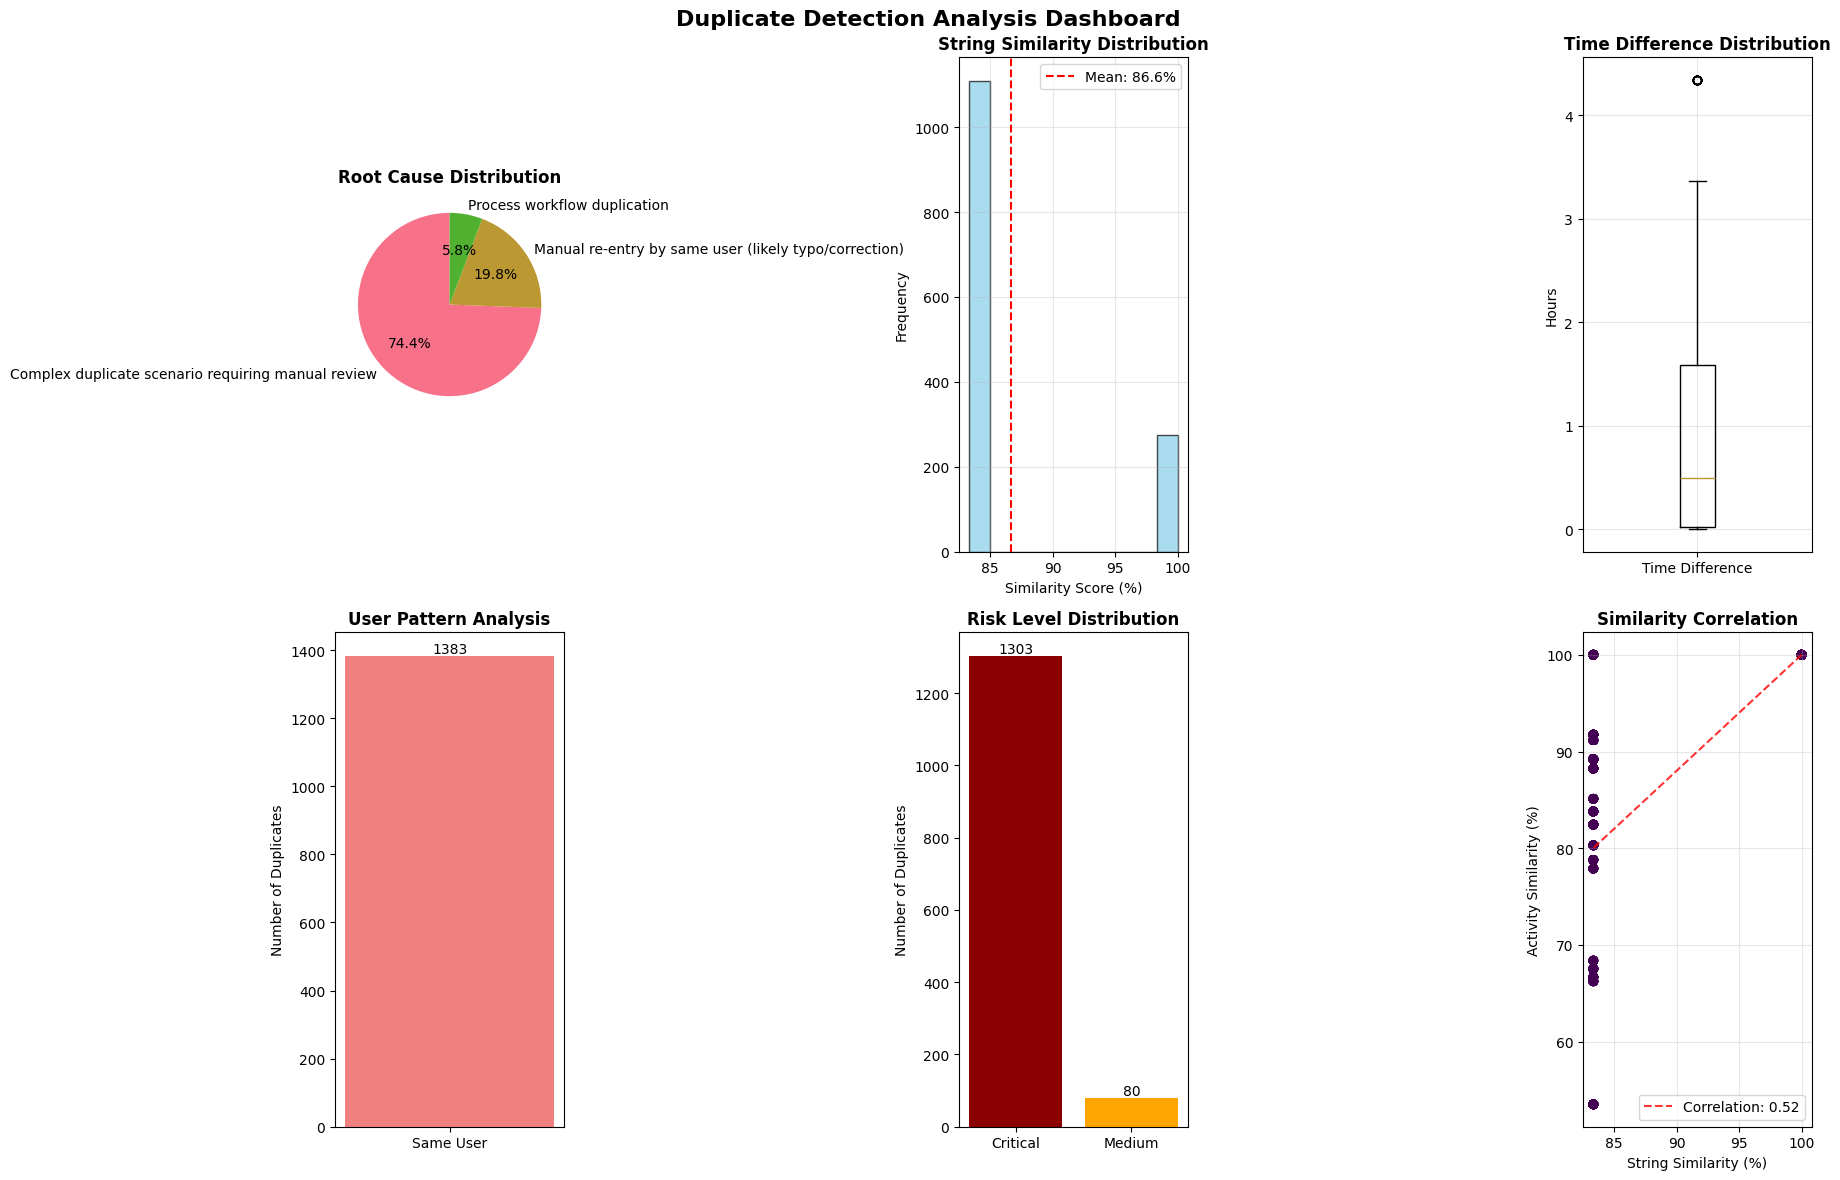

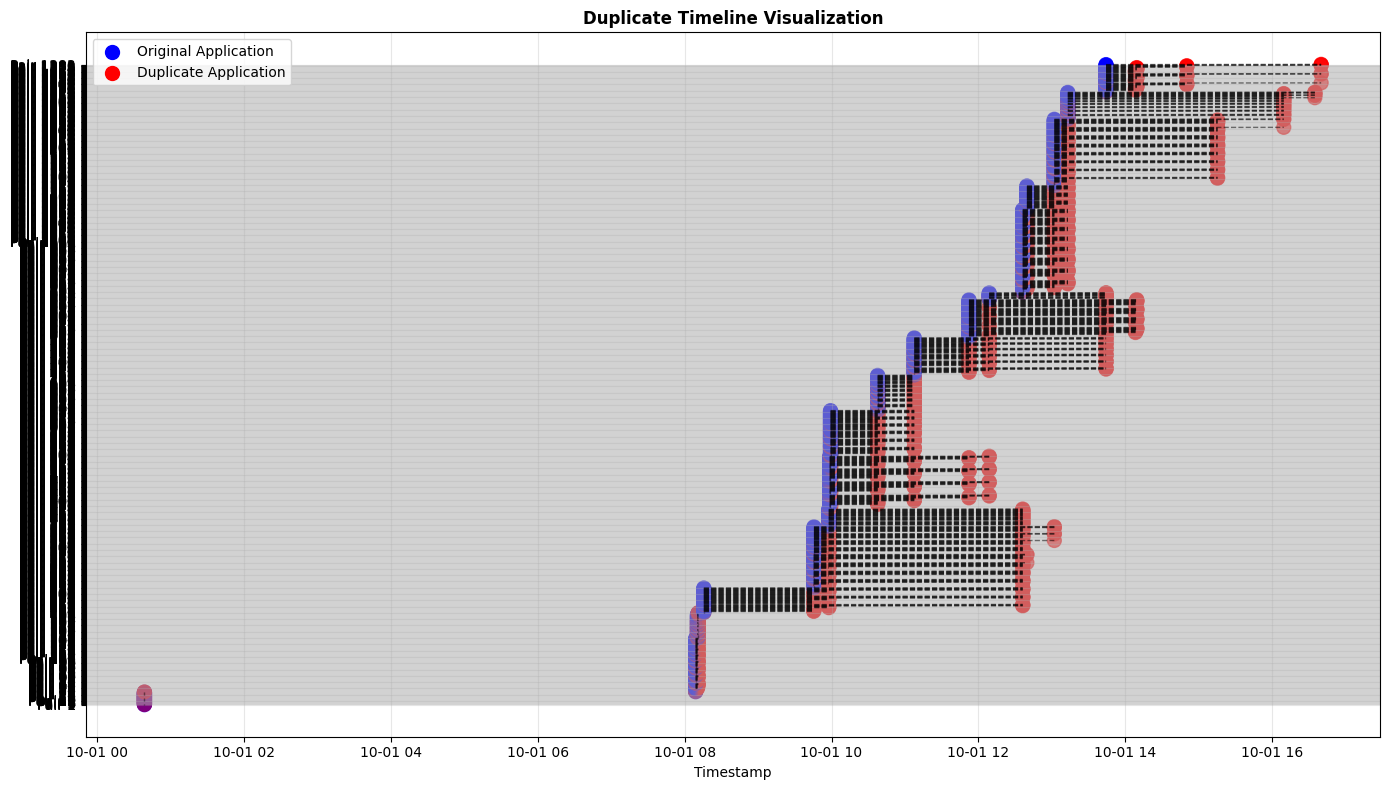


🎯 ACTIONABLE RECOMMENDATIONS

📈 TOP RECOMMENDATIONS (by frequency):
   1. Immediate manual review and process audit required (1303 cases)
   2. Implement real-time duplicate checking and user coordination (80 cases)

⚠️  RISK-BASED PRIORITIES:
   🔴 CRITICAL: Immediate manual review and process audit required
   🔴 MEDIUM: Implement real-time duplicate checking and user coordination

📊 ADDITIONAL INSIGHTS

�� DETECTION EFFECTIVENESS:
   • High Similarity Duplicates (>90%): 274
   • Medium Similarity Duplicates (80-90%): 1109
   • Quick Duplicates (<1 hour): 922
   • Same-day Duplicates (<24 hours): 1383

⏱️  TEMPORAL PATTERNS:
   • Average time between duplicates: 0.9 hours
   • Median time between duplicates: 0.5 hours
   • Fastest duplicate: 0.00 hours
   • Slowest duplicate: 4.3 hours


In [19]:
# =========================================
# Enhanced Results Display with Tabular Format and Visualizations (Fixed)
# =========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# =========================================
# 1. Tabular Results Display (Fixed)
# =========================================
def display_results_tabular(duplicate_pairs, impact_df):
    """
    Display results in clean tabular format
    """
    print("=" * 80)
    print("DUPLICATE DETECTION RESULTS SUMMARY")
    print("=" * 80)
    
    # Summary statistics
    print(f"\n�� SUMMARY STATISTICS:")
    print(f"   • Total Duplicate Pairs Found: {len(duplicate_pairs)}")
    print(f"   • Average String Similarity: {duplicate_pairs['String_Similarity'].mean():.1f}%")
    print(f"   • Average Time Difference: {duplicate_pairs['Time_Difference_Hours'].mean():.1f} hours")
    
    # Fix the Same_User issue by converting to boolean and handling properly
    if 'Same_User' in duplicate_pairs.columns:
        # Convert to boolean, handling any non-boolean values
        same_user_bool = duplicate_pairs['Same_User'].astype(bool)
        same_user_count = same_user_bool.sum()
        different_user_count = len(duplicate_pairs) - same_user_count
        print(f"   • Same User Duplicates: {same_user_count}")
        print(f"   • Different User Duplicates: {different_user_count}")
    else:
        print("   • User analysis not available")
    
    # Detailed results table
    print(f"\n�� DETAILED DUPLICATE PAIRS:")
    table_data = []
    for idx, row in duplicate_pairs.iterrows():
        # Handle Same_User column safely
        same_user_display = "Yes" if row.get('Same_User', 0) == 1.0 else "No"
        
        table_data.append([
            idx + 1,
            row['Application_A'],
            row['Application_B'],
            f"{row['String_Similarity']:.1f}%",
            f"{row['Time_Difference_Hours']:.1f}h",
            same_user_display,
            f"{row['Activity_Similarity']:.1f}%",
            row['Root_Cause']
        ])
    
    headers = ["#", "App A", "App B", "String Sim", "Time Gap", "Same User", "Activity Sim", "Root Cause"]
    print(tabulate(table_data, headers=headers, tablefmt="grid", stralign="center"))
    
    # Impact analysis table
    if len(impact_df) > 0:
        print(f"\n💰 IMPACT ANALYSIS:")
        impact_table = []
        for idx, row in impact_df.iterrows():
            impact_table.append([
                idx + 1,
                f"{row['Application_A']} ↔ {row['Application_B']}",
                row['Risk_Level'],
                f"${row['Potential_Financial_Impact']:,.0f}" if row['Potential_Financial_Impact'] > 0 else "N/A",
                row['Recommendation'][:50] + "..." if len(row['Recommendation']) > 50 else row['Recommendation']
            ])
        
        impact_headers = ["#", "Applications", "Risk Level", "Financial Impact", "Recommendation"]
        print(tabulate(impact_table, headers=impact_headers, tablefmt="grid", stralign="left"))

# =========================================
# 2. Comprehensive Visualizations (Fixed)
# =========================================
def create_visualizations(duplicate_pairs, impact_df):
    """
    Create comprehensive visualizations for duplicate analysis
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Duplicate Detection Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Root Cause Distribution (Pie Chart)
    if len(duplicate_pairs) > 0:
        root_causes = duplicate_pairs['Root_Cause'].value_counts()
        axes[0, 0].pie(root_causes.values, labels=root_causes.index, autopct='%1.1f%%', startangle=90)
        axes[0, 0].set_title('Root Cause Distribution', fontweight='bold')
    
    # 2. Similarity Score Distribution (Histogram)
    axes[0, 1].hist(duplicate_pairs['String_Similarity'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 1].axvline(duplicate_pairs['String_Similarity'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {duplicate_pairs["String_Similarity"].mean():.1f}%')
    axes[0, 1].set_title('String Similarity Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Similarity Score (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Time Difference Analysis (Box Plot)
    time_data = [duplicate_pairs['Time_Difference_Hours']]
    axes[0, 2].boxplot(time_data, labels=['Time Difference'])
    axes[0, 2].set_title('Time Difference Distribution', fontweight='bold')
    axes[0, 2].set_ylabel('Hours')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. User Pattern Analysis (Bar Chart) - Fixed
    if 'Same_User' in duplicate_pairs.columns:
        # Convert to boolean safely
        same_user_bool = duplicate_pairs['Same_User'].astype(bool)
        user_patterns = same_user_bool.value_counts()
        
        if len(user_patterns) > 0:
            user_labels = []
            user_counts = []
            
            if False in user_patterns.index:
                user_labels.append('Different Users')
                user_counts.append(user_patterns[False])
            if True in user_patterns.index:
                user_labels.append('Same User')
                user_counts.append(user_patterns[True])
            
            if user_labels:
                bars = axes[1, 0].bar(user_labels, user_counts, color=['lightcoral', 'lightgreen'])
                axes[1, 0].set_title('User Pattern Analysis', fontweight='bold')
                axes[1, 0].set_ylabel('Number of Duplicates')
                
                # Add value labels on bars
                for bar, count in zip(bars, user_counts):
                    if count > 0:
                        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                                       str(count), ha='center', va='bottom')
        else:
            axes[1, 0].text(0.5, 0.5, 'No User Data\nAvailable', ha='center', va='center', 
                           transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('User Pattern Analysis', fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'No User Data\nAvailable', ha='center', va='center', 
                       transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('User Pattern Analysis', fontweight='bold')
    
    # 5. Risk Level Distribution (if impact analysis available)
    if len(impact_df) > 0:
        risk_levels = impact_df['Risk_Level'].value_counts()
        colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red', 'Critical': 'darkred'}
        risk_colors = [colors.get(level, 'gray') for level in risk_levels.index]
        
        bars = axes[1, 1].bar(risk_levels.index, risk_levels.values, color=risk_colors)
        axes[1, 1].set_title('Risk Level Distribution', fontweight='bold')
        axes[1, 1].set_ylabel('Number of Duplicates')
        
        # Add value labels
        for bar, count in zip(bars, risk_levels.values):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                           str(count), ha='center', va='bottom')
    else:
        axes[1, 1].text(0.5, 0.5, 'No Impact Analysis\nAvailable', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Risk Level Distribution', fontweight='bold')
    
    # 6. Activity Similarity vs String Similarity (Scatter Plot) - Fixed
    if 'Same_User' in duplicate_pairs.columns:
        # Convert to boolean for coloring
        same_user_bool = duplicate_pairs['Same_User'].astype(bool)
        scatter_colors = same_user_bool.astype(int)  # Convert to 0/1 for coloring
    else:
        scatter_colors = [0] * len(duplicate_pairs)  # Default color
    
    axes[1, 2].scatter(duplicate_pairs['String_Similarity'], duplicate_pairs['Activity_Similarity'], 
                      c=scatter_colors, cmap='viridis', alpha=0.7)
    axes[1, 2].set_xlabel('String Similarity (%)')
    axes[1, 2].set_ylabel('Activity Similarity (%)')
    axes[1, 2].set_title('Similarity Correlation', fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add correlation line
    if len(duplicate_pairs) > 1:
        try:
            z = np.polyfit(duplicate_pairs['String_Similarity'], duplicate_pairs['Activity_Similarity'], 1)
            p = np.poly1d(z)
            axes[1, 2].plot(duplicate_pairs['String_Similarity'], p(duplicate_pairs['String_Similarity']), 
                           "r--", alpha=0.8, label=f'Correlation: {np.corrcoef(duplicate_pairs["String_Similarity"], duplicate_pairs["Activity_Similarity"])[0,1]:.2f}')
            axes[1, 2].legend()
        except:
            # Handle case where correlation can't be calculated
            pass
    
    plt.tight_layout()
    plt.show()

# =========================================
# 3. Process Flow Visualization (Fixed)
# =========================================
def create_process_flow_visualization(duplicate_pairs):
    """
    Create a process flow diagram showing duplicate patterns
    """
    if len(duplicate_pairs) == 0:
        print("No duplicates found for process flow visualization")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Create a timeline visualization
    y_positions = []
    colors = []
    labels = []
    
    for idx, row in duplicate_pairs.iterrows():
        # Get first timestamp from each trace
        trace_a_time = None
        trace_b_time = None
        
        try:
            if row['Trace_A'] and len(row['Trace_A']) > 0:
                trace_a_time = pd.to_datetime(row['Trace_A'][0]['timestamp'])
            if row['Trace_B'] and len(row['Trace_B']) > 0:
                trace_b_time = pd.to_datetime(row['Trace_B'][0]['timestamp'])
        except:
            continue
        
        if trace_a_time and trace_b_time:
            y_positions.extend([idx * 2, idx * 2 + 1])
            colors.extend(['blue', 'red'])
            labels.extend([f"App {row['Application_A']}", f"App {row['Application_B']}"])
    
    if y_positions:
        # Create timeline
        times = []
        for _, row in duplicate_pairs.iterrows():
            try:
                if row['Trace_A'] and len(row['Trace_A']) > 0:
                    times.append(pd.to_datetime(row['Trace_A'][0]['timestamp']))
                if row['Trace_B'] and len(row['Trace_B']) > 0:
                    times.append(pd.to_datetime(row['Trace_B'][0]['timestamp']))
            except:
                continue
        
        if times:
            ax.scatter(times, y_positions, c=colors, s=100, alpha=0.7)
            
            # Add connecting lines for duplicate pairs
            for idx, row in duplicate_pairs.iterrows():
                try:
                    if row['Trace_A'] and row['Trace_B'] and len(row['Trace_A']) > 0 and len(row['Trace_B']) > 0:
                        time_a = pd.to_datetime(row['Trace_A'][0]['timestamp'])
                        time_b = pd.to_datetime(row['Trace_B'][0]['timestamp'])
                        ax.plot([time_a, time_b], [idx * 2, idx * 2 + 1], 'k--', alpha=0.5, linewidth=1)
                except:
                    continue
            
            ax.set_yticks(range(0, len(duplicate_pairs) * 2, 2))
            ax.set_yticklabels([f"Pair {i+1}" for i in range(len(duplicate_pairs))])
            ax.set_xlabel('Timestamp')
            ax.set_title('Duplicate Timeline Visualization', fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Add legend
            ax.scatter([], [], c='blue', label='Original Application', s=100)
            ax.scatter([], [], c='red', label='Duplicate Application', s=100)
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# =========================================
# 4. Recommendations Summary (Fixed)
# =========================================
def display_recommendations_summary(impact_df):
    """
    Display actionable recommendations in a structured format
    """
    if len(impact_df) == 0:
        print("No impact analysis available for recommendations")
        return
    
    print("\n" + "=" * 80)
    print("🎯 ACTIONABLE RECOMMENDATIONS")
    print("=" * 80)
    
    # Group recommendations by type
    recommendations = impact_df['Recommendation'].value_counts()
    
    print(f"\n📈 TOP RECOMMENDATIONS (by frequency):")
    for i, (rec, count) in enumerate(recommendations.items(), 1):
        print(f"   {i}. {rec} ({count} cases)")
    
    # Risk-based recommendations
    print(f"\n⚠️  RISK-BASED PRIORITIES:")
    risk_priorities = impact_df.groupby('Risk_Level').agg({
        'Recommendation': lambda x: x.value_counts().index[0] if len(x) > 0 else "No recommendation",
        'Potential_Financial_Impact': 'sum'
    }).sort_index()
    
    for risk_level in ['Critical', 'High', 'Medium', 'Low']:
        if risk_level in risk_priorities.index:
            rec = risk_priorities.loc[risk_level, 'Recommendation']
            impact = risk_priorities.loc[risk_level, 'Potential_Financial_Impact']
            print(f"   🔴 {risk_level.upper()}: {rec}")
            if impact > 0:
                print(f"      💰 Potential Impact: ${impact:,.0f}")

# =========================================
# 5. Execute All Visualizations (Fixed)
# =========================================
def run_complete_analysis(duplicate_pairs, impact_df):
    """
    Run the complete analysis with all visualizations
    """
    # Display tabular results
    display_results_tabular(duplicate_pairs, impact_df)
    
    # Create visualizations
    create_visualizations(duplicate_pairs, impact_df)
    
    # Create process flow visualization
    create_process_flow_visualization(duplicate_pairs)
    
    # Display recommendations
    display_recommendations_summary(impact_df)
    
    # Additional summary statistics
    print(f"\n" + "=" * 80)
    print("📊 ADDITIONAL INSIGHTS")
    print("=" * 80)
    
    if len(duplicate_pairs) > 0:
        print(f"\n�� DETECTION EFFECTIVENESS:")
        print(f"   • High Similarity Duplicates (>90%): {(duplicate_pairs['String_Similarity'] > 90).sum()}")
        print(f"   • Medium Similarity Duplicates (80-90%): {((duplicate_pairs['String_Similarity'] >= 80) & (duplicate_pairs['String_Similarity'] <= 90)).sum()}")
        print(f"   • Quick Duplicates (<1 hour): {(duplicate_pairs['Time_Difference_Hours'] < 1).sum()}")
        print(f"   • Same-day Duplicates (<24 hours): {(duplicate_pairs['Time_Difference_Hours'] < 24).sum()}")
        
        print(f"\n⏱️  TEMPORAL PATTERNS:")
        print(f"   • Average time between duplicates: {duplicate_pairs['Time_Difference_Hours'].mean():.1f} hours")
        print(f"   • Median time between duplicates: {duplicate_pairs['Time_Difference_Hours'].median():.1f} hours")
        print(f"   • Fastest duplicate: {duplicate_pairs['Time_Difference_Hours'].min():.2f} hours")
        print(f"   • Slowest duplicate: {duplicate_pairs['Time_Difference_Hours'].max():.1f} hours")

# Run the complete analysis
print("🚀 Running Complete Duplicate Analysis...")
run_complete_analysis(duplicate_pairs, impact_df)